Copyright (c) 2017 [Geosoft Inc.](geosoft.com)

https://github.com/GeosoftInc/gxpy

[BSD 2-clause License](https://github.com/GeosoftInc/gxpy/blob/master/LICENSE)

# Geosoft Databases

### Lessons

<!--- # Run this from a code cell to create TOC markdown: -->
<!--- import geosoft.gxpy.utility; print(geosoft.gxpy.utility.jupyter_markdown_toc('geosoft databases')) -->
 1. [What is a Geosoft database?](#What-is-a-Geosoft-database?)
 2. [Create a new database from a CSV-format data file](#Create-a-new-database-from-a-CSV-format-data-file)
 3. [Split the data into lines](#Split-the-data-into-lines)
 4. [Read, modify and save data using numpy](#Read,-modify-and-save-data-using-numpy)
 5. [Read, modify and save data using a VV](#Read,-modify-and-save-data-using-a-VV)
 6. [Apply an expression to a database](#Apply-an-expression-to-a-database)
 
## What is a Geosoft database?

A Geosoft database stores 3D spatial data in a form that allows for both very-large volume data storage and very efficient processing.  Geosoft databases are stored on a file system in a file that has extension _.gdb_.

The Geosoft database was first designed in 1992 and has evolved to become a de facto standard for airborne and ground geophysical data, geochemical data, and drillhole data of all kinds.  All Geosoft programs and third-party applications that use the Geosoft API to read databases are able to work with databases created by any version of Geosoft since 1992, though database features and capabilities that are newer than the reading program will not be available to older programs. This cross-version stability of data has been key to the emergence of Geosoft databases as an industry standard, especially for airborne geophysical surveys.

Fundamentally, Geosoft databases store located data which has either an (x, y) location for 2D data, or an (x, y, z) location for 3D data such that each location may have any number of fields of associated information.  Information fields are referred to as 'channels' in the context of a Geosoft Database, and channels may contain numeric data, strings or arrays of numeric data to store things like time-series.  For example an airborne magnetic survey may have (x, y, elevation, altimeter, mag) data, and a ground geochemical survey may contain (x, y, elevation, Cu, Au, Hg).

Data in a database is grouped into the concept of 'lines' of data such that each 'line' contains the data from a single airborne survey line, a single ground survey line, a marine ship track, a set of data from a single drill hole, or from any other grouping construct that is suitable for the stored data.  Geosoft's desktop application, Oasis montaj, displays a single line of data in a spreadsheet-like form to the user, allowing a user to change lines and change which channels are displayed and the order channels are displayed. Simple databases might place all data into a single line.  All lines in a Geosoft database share the channel definitions, of course with data different for each line. 

As you work through the exercises in this tutorial you will be introduced to other concepts of Geosoft databases.

### Imports, GX context, and get data from GitHub

In [1]:
from IPython.display import Image
import numpy as np
import geosoft.gxapi as gxapi
import geosoft.gxpy.gx as gx
import geosoft.gxpy.gdb as gxdb
import geosoft.gxpy.utility as gxu
gxc = gx.GXpy()

url = 'https://github.com/GeosoftInc/gxpy/raw/9.3.1/examples/data/'
gxu.url_retrieve(url + 'mag_data.csv')

'mag_data.csv'

## Create a new database from a CSV-format data file

A very common form for exchanging located data is in a simple ASCII Comma-Separated-Values (CSV) file. In this exercise we 
will create a new Geosoft database and import an example CSV file.

The CSV file mag_data.csv contains located data as follows:
    
```
# (X, Y) are on NAD83, UTM Zone 15N
X,Y,Z,mag
330000,6629200,211.055369153511,5535
330050,6629200,210.654999327171,5500
330100,6629200,210.286555185181,5476
330150,6629200,209.952679145607,5479
330200,6629200,209.655742280775,5496
330250,6629200,209.397817201372,5544
etc...
```

In this example, the first line is simply a comment line that identified the spatial coordinate system for the located data.
The second line identified the names of the data columns, and data follows starting in line 3. 
Note that columns of information after the first line are comma-delimited, and each line has 4 columns of information.

### Import CSV Script

This script that will import the CSV data into a new Geosoft database.  All 
the data is imported to a single line - we wil split the line into segments later.

['L0']
['mag', 'X', 'Y', 'Z']
('X', 'Y', 'Z')


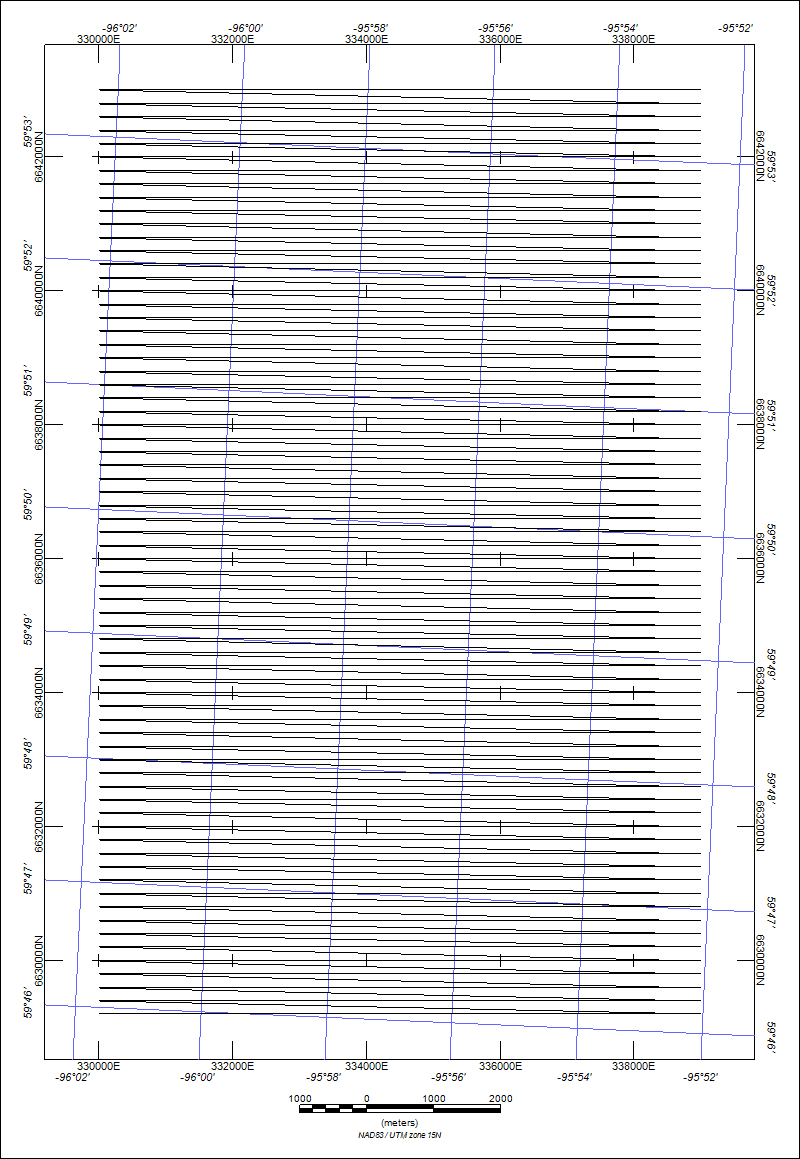

In [2]:
# Open csv-format data file and skip the first line, which is a comment line
f = open('mag_data.csv', 'r')
f.readline()

# the second line contains the channel/field names, from which we create a list of channel names
channel_names = f.readline().strip().split(',')

#the rest of the file contains data, which we load into a 2D numpy float array
data = np.loadtxt(f, delimiter=',')

#create a new database from list of channels and numpy data. All data is stored in a single line.
with gxdb.Geosoft_gdb.new('mag_data', overwrite=True) as gdb:
    
    # create a valid line name for line 0 type random, and write all the data to this line
    gdb.write_line('L0', data, channel_names)

    # set the coordinate system to 'NAD 83 / UTM zone 15N'
    gdb.coordinate_system = 'NAD83 / UTM zone 15N'

    # set the mag data units to 'nT'
    gxdb.Channel(gdb, 'mag').unit_of_measure = 'nT'
    
    print(list(gdb.list_lines()))     # ['L0']
    print(list(gdb.list_channels()))  # ['mag', 'X', 'Y', 'Z']
    print(gdb.xyz_channels)           # ('X', 'Y', 'Z')

Image(gxdb.Geosoft_gdb.open('mag_data').figure_map(draw=gxdb.DRAW_AS_LINES).image_file(pix_width=800))

Opening the database from a Geosoft application will shows the 'L0' line.

![](https://github.com/GeosoftInc/gxpy/raw/9.3/examples/tutorial/Geosoft%20Databases/gdb1.png)


## Split the data into lines

In the database line plot above we see that the data in Line 0 (L0E) would be better organized as separate survey lines rather than a single contuous lines.  In this case the lines are horizontal, 200 m apart with sampled every 50 m along each line:

Lets modify the script by adding some processing that will use a Geosoft method to split a line into separate lines based on a change in line direction. To split a line into sections we will use a processing function from the GXAPI, which exposes the full Geosoft API.

We will use the  [geosoft.gxapi.GXDU.split_line_xy2](https://geosoftinc.github.io/gxpy/9.3/python/GXDU.html?highlight=split_line_xy2#geosoft.gxapi.GXDU.split_line_xy2) function ([GXDU](https://geosoftinc.github.io/gxpy/9.3/python/GXDU.html) contains many Database Utility functions). This is part of the low-level [geosoft.gxapi](https://geosoftinc.github.io/gxpy/9.3/python/geosoft.gxapi.classes.html#geosoft-gxapi-classes) so a bit more care is required. Database functions often require locks on database symbols (handles to lines, channels and other database objects), which is the case for the _Line_, _x_ch_ and _y_ch_ arguments of split_line_xy2. Because Geosoft databases allow for concurrent access by multiple applications, symbols must be locked and unlocked as they are used.  The `geosoft.gxpy` pythonic api will do this for you, but the `geosoft.gxapi` requires that you directly manage locks. Terminating a script removes any locks that may have remained on any symbols.

Lines:  ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15', 'L16', 'L17', 'L18', 'L19', 'L20', 'L21', 'L22', 'L23', 'L24', 'L25', 'L26', 'L27', 'L28', 'L29', 'L30', 'L31', 'L32', 'L33', 'L34', 'L35', 'L36', 'L37', 'L38', 'L39', 'L40', 'L41', 'L42', 'L43', 'L44', 'L45', 'L46', 'L47', 'L48', 'L49', 'L50', 'L51', 'L52', 'L53', 'L54', 'L55', 'L56', 'L57', 'L58', 'L59', 'L60', 'L61', 'L62', 'L63', 'L64', 'L65', 'L66', 'L67', 'L68', 'L69', 'L70']


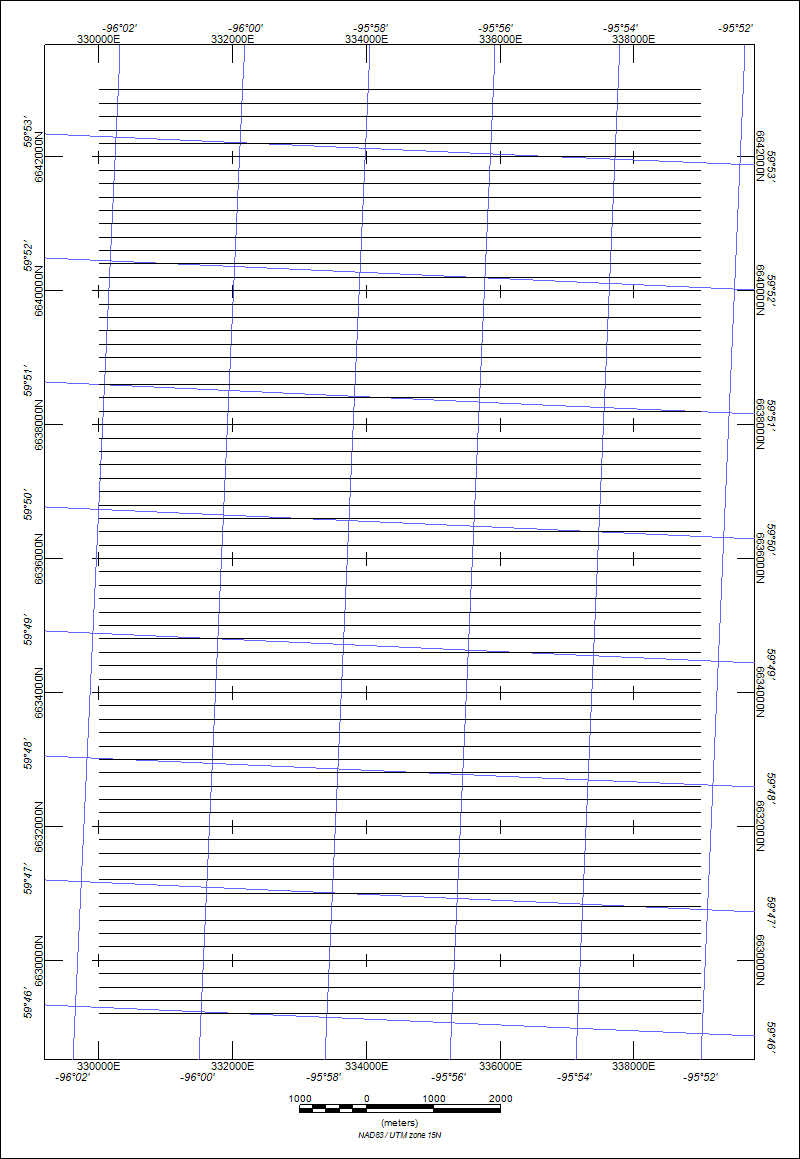

In [3]:
# split the line into sections knowing lines are E-W, and separated by 200 m.

# the GXDU class requires a desktop license
if gxc.entitled:

    # we need an int_ref() to hold values that are passed by reference, in this case for the first_line argument
    split_line_number_start = gxapi.int_ref()
    split_line_number_start.value = 1

    # open the database, best practice is to use a 'with ...' construct
    with gxdb.Geosoft_gdb.open('mag_data') as gdb:

        # create instances to the lines and channels needed by the split_line_xy2 function
        line = gxdb.Line(gdb, 'L0')
        x_channel = gxdb.Channel(gdb, 'X')
        y_channel = gxdb.Channel(gdb, 'Y')

        # lock items as required
        line.lock = gxdb.SYMBOL_LOCK_READ
        x_channel.lock = gxdb.SYMBOL_LOCK_WRITE
        y_channel.lock = gxdb.SYMBOL_LOCK_WRITE

        # split the original line into segments, based on a lateral distance tolerance of 100 m.
        gxapi.GXDU.split_line_xy2(
            gdb.gxdb,                     # the gxdb property holds the gxapi.GXDB instance
            line.symbol,
            gxdb.Channel(gdb, 'X').symbol,
            gxdb.Channel(gdb, 'Y').symbol,
            1,
            100.0,
            gxapi.rDUMMY,
            gxapi.DU_SPLITLINE_SEQUENTIAL,
            split_line_number_start,
            1,
            1)

        #delete the original line as it is no longer needed
        gdb.delete_line('L0')

        # print a list of the new lines
        print('Lines: ', list(gdb.list_lines()))   # ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', ...
    
# show the lines
Image(gxdb.Geosoft_gdb.open('mag_data').figure_map(draw=gxdb.DRAW_AS_LINES).image_file(pix_width=800))

## Read, modify and save data using numpy

Geosoft databases and data models are designed around the concept of data vector arrays, which support high performance data processing. Each channel in a line holds a single 1-dimensional or 2-dimentional array of data. Python's standard library for working with data arrays is numpy, and this is a standard part of any scientifically-oriented Python environment. The `Geosoft_gdb` class provides for reading and writing data directly to/from numpy arrays as well as Geosoft `VV` vector arrays.

This example shows a simple use of numpy and the next section shows the same exercise using a Geosoft `VV`. In the open database above we see that the mag data has values around 5000 nT, which we will subtract from the data.

In [4]:
with gxdb.Geosoft_gdb.open('mag_data') as gdb:
 
    # make a new channel for the output, duplicate properties of 'mag' channel
    new_mag_channel = gxdb.Channel.new(gdb, 'mag_base', dup='mag', replace=True)
 
    # work through each line
    for line in gdb.list_lines():
 
        # read data from the line.
        # The read_channel method returns the data as a numpy array, and the fiducial
        mag_data, fid = gdb.read_channel(line, 'mag')
 
        # use simple numpy math to subtract 5000, then save to the new_mag_channel
        mag_data = mag_data - 5000
        gdb.write_channel(line, new_mag_channel, mag_data, fid)

![](https://github.com/GeosoftInc/gxpy/raw/9.3/examples/tutorial/Geosoft%20Databases/gdb5.png)

## Read, modify and save data using a VV

This example does the same thing as the previous example, but uses the Geosoft vector processing functions from the Geosoft VV library. Geosoft VV functions will deliver even higher performance than numpy, and while you may be limited by the capabilities of the Geosoft API, there are many functions that perform geoscience-specific operations on data (see [gxapi.GXVVU](https://geosoftinc.github.io/gxpy/9.3/python/GXVVU.html)). Note that data in a Geosoft VV can also be exposed as a numpy array to provide numpy access when needed.

In [5]:
with gxdb.Geosoft_gdb.open('mag_data') as gdb:
 
    # make a new channel for the output, duplicate properties of 'mag' channel
    new_mag_channel = gxdb.Channel.new(gdb, 'mag_base', dup='mag', replace=True)
 
    # work through each line
    for line in gdb.list_lines():
 
        # read data from the line.
        # The read_channel method returns the data in a geosoft VV
        mag_data = gdb.read_channel_vv(line, 'mag')
 
        # use Geosoft GXVVU.translate function to subtract 5000.
        gxapi.GXVVU.translate(mag_data.gxvv, -5000, 1)
        gdb.write_channel_vv(line, new_mag_channel, mag_data)

## Apply an expression to a database

In this exercise we calculate the distance along each line from the starting point of each line. The Pythagorean expression is simple and can be implemented in a single line of numpy code. This example reads multiple channels from the database and uses numpy slicing to work with individual channel columns from a 2D numpy array.

In [6]:
with gxdb.Geosoft_gdb.open('mag_data') as gdb:
 
    # make a distance channel
    dist_channel = gxdb.Channel.new(gdb, 'distance', dup='x', replace=True)
 
    # work through each line
    for line in gdb.list_lines():
 
        # Here we are reading multiple channels from a single line. 
        # If we were to omit the list of channels ('x', 'y'), 
        # all channels in the line would be returned in a 2D numpy array. 
        # The returned channels_read is a list of the channels that were read.
        xy_data, channels_read, fid = gdb.read_line(line, ('x', 'y'))
 
        # get the first point (x0, y0)       
        x0 = xy_data[0, 0]
        y0 = xy_data[0, 1]
         
        # use numpy array math to calculate distance in a 1D array dist_array
        dist_array = np.sqrt((xy_data[:, 0] - x0)**2 + (xy_data[:, 1] - y0)**2)
         
        # save the distance to the distance channel
        gdb.write_channel(line, dist_channel, dist_array, fid)

Above we use numpy vector operations which are very fast. You could also iterate through the array, but this is much slower:

In [7]:
import math

with gxdb.Geosoft_gdb.open('mag_data') as gdb:
 
    # make a distance channel
    dist_channel = gxdb.Channel.new(gdb, 'distance', dup='x', replace=True)
 
    # work through each line
    for line in gdb.list_lines():
 
        # Here we are reading multiple channels from a single line. 
        # If we were to omit the list of channels ('x', 'y'), 
        # all channels in the line would be returned in a 2D numpy array. 
        # The returned channels_read is a list of the channels that were read.
        xy_data, channels_read, fid = gdb.read_line(line, ('x', 'y'))
 
        # get the first point (x0, y0)       
        x0 = xy_data[0, 0]
        y0 = xy_data[0, 1]
        
        # iterate elements in the data (slow)
        dist_array = np.zeros(len(xy_data))
        for i in range(len(dist_array)):
            dx = xy_data[i, 0] - x0
            dy = xy_data[i, 1] - y0
            dist_array[i] = math.sqrt(dx **2 + dy **2)
         
        # save the distance to the distance channel
        gdb.write_channel(line, dist_channel, dist_array, fid)